## Phase 1

In [1]:
pip install PyPortfolioOpt pandas yfinance

   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 1.1/1.1 MB 5.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/19.1 MB ? eta -:--:--
   - -------------------------------------- 0.8/19.1 MB 4.2 MB/s eta 0:00:05
   --- ------------------------------------ 1.6/19.1 MB 3.8 MB/s eta 0:00:05
   ---- ----------------------------------- 2.4/19.1 MB 3.9 MB/s eta 0:00:05
   ------- -------------------------------- 3.4/19.1 MB 3.9 MB/s eta 0:00:04
   -------- ------------------------------- 4.2/19.1 MB 3.9 MB/s eta 0:00:04
   ---------- ----------------------------- 5.0/19.1 MB 3.9 MB/s eta 0:00:04
   ------------ --------------------------- 5.8/19.1 MB 3.9 MB/s eta 0:00:04
   ------------- -------------------------- 6.6/19.1 MB 3.9 MB/s eta 0:00:04
   --------------- ------------------------ 7.3/19.1 MB 3.9 MB/s eta 0:00:03
   ----------------- ---------------------- 8.1/19.1 MB 3.9 MB/s eta 0:00:03
   ------------


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import yfinance as yf
import pandas as pd
from pypfopt import EfficientFrontier, risk_models, expected_returns
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

In [2]:
# define tickers and download historical data
tickers = ["MSFT", "AAPL", "GOOG", "AMZN", "TSLA"]

# Force group by ticker
df = yf.download(tickers, start="2020-01-01", end="2024-12-31")['Close']

C:\Users\nikib\AppData\Local\Temp\ipykernel_1408\3406859348.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start="2020-01-01", end="2024-12-31")['Close']
[*********************100%***********************]  5 of 5 completed


In [3]:
df

Ticker,AAPL,AMZN,GOOG,MSFT,TSLA
Date,,,,,
2020-01-02,72.538513,94.900497,67.964508,152.791092,28.684000
2020-01-03,71.833290,93.748497,67.630989,150.888641,29.534000
2020-01-06,72.405670,95.143997,69.298584,151.278580,30.102667
2020-01-07,72.065155,95.343002,69.255333,149.899338,31.270666
2020-01-08,73.224403,94.598503,69.801094,152.286926,32.809334
...,...,...,...,...,...
2024-12-23,254.367035,225.059998,195.531952,432.871429,430.600006
2024-12-24,257.286682,229.050003,197.108246,436.929108,462.279999
2024-12-26,258.103729,227.050003,196.639343,435.715790,454.130005


MPT requires two things:
expected annual returns
covariance matrix

In [4]:
# 2. Calculate expected returns 
mu=expected_returns.mean_historical_return(df)*100
mu

Ticker
AAPL    28.313162
AMZN    18.515949
GOOG    23.196900
MSFT    22.639061
TSLA    71.129682
dtype: float64

In [5]:
# Calculate Covariance Matrix
S=risk_models.sample_cov(df)
S

Ticker,AAPL,AMZN,GOOG,MSFT,TSLA
Ticker,,,,,
AAPL,0.100420,0.067507,0.066485,0.072340,0.102752
AMZN,0.067507,0.129425,0.075865,0.074460,0.104534
GOOG,0.066485,0.075865,0.104930,0.073474,0.087053
MSFT,0.072340,0.074460,0.073474,0.093066,0.091489
TSLA,0.102752,0.104534,0.087053,0.091489,0.451442


In [6]:
# Performing optimization
ef=EfficientFrontier(mu,S)

# maximize sharpe ratio
weights=ef.max_sharpe()

# clean the weights (remove very small allocations)
cleaned_weights=ef.clean_weights()

In [7]:
ef.portfolio_performance(verbose=True)

Expected annual return: 4529.7%
Annual volatility: 39.4%
Sharpe Ratio: 114.85


(45.29699464122051, 0.3943876531706742, 114.85398763641795)

In [8]:
# results
print("Optimal Asset Weights:")
print(cleaned_weights)
print("-"*30)

Optimal Asset Weights:
OrderedDict({'AAPL': 0.4662, 'AMZN': 0.0, 'GOOG': 0.1225, 'MSFT': 0.0, 'TSLA': 0.4113})
------------------------------


In [9]:
# Optional: Get the number of shares to buy for a given portfolio value
latest_prices = get_latest_prices(df)
total_portfolio_value = 100000 # Example: $100,000

da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=total_portfolio_value)
allocation, leftover = da.lp_portfolio()

print(f"Discrete allocation for a ${total_portfolio_value:,.2f} portfolio:")
print(allocation)
print(f"Funds remaining: ${leftover:.2f}")

Discrete allocation for a $100,000.00 portfolio:
{'AAPL': 186, 'GOOG': 64, 'TSLA': 98}
Funds remaining: $47.22


Stock volatility is the degree to which a stock's price fluctuates over a given period, indicating the level of risk and uncertainty associated with that stock. A stock with high volatility experiences rapid and large price swings, potentially offering big gains or significant losses, while a low-volatility stock has a steadier, more predictable price movement. Volatility is quantified using statistical measures like standard deviation, which shows how spread out a stock's returns are, with a greater standard deviation meaning more volatility. 


## Phase 2

In [10]:
import yfinance as yf
import pandas as pd
import numpy as np
from pypfopt import EfficientFrontier, risk_models, expected_returns

In [52]:
#  1. Setup and data preparation
# Define tickers and the benchmark
tickers = ["MSFT", "AAPL", "GOOG", "AMZN", "TSLA"]
benchmark_ticker = "SPY"

# Download historical data for a longer period (e.g., 10 years)
all_tickers = tickers + [benchmark_ticker]
all_data = yf.download(all_tickers, start="2015-01-01", end="2024-12-31")['Close']

C:\Users\nikib\AppData\Local\Temp\ipykernel_1408\3170327093.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  all_data = yf.download(all_tickers, start="2015-01-01", end="2024-12-31")['Close']
[*********************100%***********************]  6 of 6 completed


In [53]:
all_data

Ticker,AAPL,AMZN,GOOG,MSFT,SPY,TSLA
Date,,,,,,
2015-01-02,24.261051,15.426000,26.014023,39.933060,171.568054,14.620667
2015-01-05,23.577572,15.109500,25.471743,39.565834,168.469559,14.006000
2015-01-06,23.579800,14.764500,24.881384,38.985115,166.882736,14.085333
2015-01-07,23.910437,14.921000,24.838755,39.480434,168.962341,14.063333
2015-01-08,24.829126,15.023000,24.917072,40.641880,171.960556,14.041333
...,...,...,...,...,...,...
2024-12-23,254.367020,225.059998,195.531937,432.871429,591.158813,430.600006
2024-12-24,257.286652,229.050003,197.108261,436.929108,597.729492,462.279999
2024-12-26,258.103729,227.050003,196.639359,435.715790,597.769348,454.130005


In [54]:
# Calculate monthly returns, as rebalancing daily is too frequent
monthly_returns = all_data.resample('ME').last().pct_change().dropna()
monthly_returns

Ticker,AAPL,AMZN,GOOG,MSFT,SPY,TSLA
Date,,,,,,
2015-02-28,0.100776,0.072293,0.044676,0.093121,0.056205,-0.001277
2015-03-31,-0.031372,-0.021202,-0.018625,-0.072748,-0.015706,-0.071653
2015-04-30,0.005786,0.133513,-0.016760,0.196262,0.009834,0.197489
2015-05-31,0.045339,0.017663,-0.009733,-0.030334,0.012856,0.109489
2015-06-30,-0.037228,0.011323,-0.021800,-0.057832,-0.020312,0.069617
...,...,...,...,...,...,...
2024-08-31,0.032353,-0.045352,-0.046434,-0.001095,0.023366,-0.077390
2024-09-30,0.017467,0.043866,0.013931,0.031548,0.021005,0.221942
2024-10-31,-0.030429,0.000376,0.032897,-0.055659,-0.008923,-0.045025


In [55]:
# Separate asset returns from benchmark returns
asset_returns = monthly_returns[tickers]
benchmark_returns = monthly_returns[benchmark_ticker]

In [57]:
# 2. create backtesting loop
# strategy parameters
rebalance_frequency=3 # Rebalance every 3 months (quarterly)
rolling_window=36 # Use 36 months (3 years) of data for each optimization

portfolio_returns = []
dates = []
all_weights = []

# The main backtesting loop
for i in range(rolling_window, len(monthly_returns)-rebalance_frequency,rebalance_frequency):
    # 1. defining current rolling window for optimization
    window_start=i-rolling_window
    window_end=i
    current_window_data=all_data.iloc[window_start:window_end]

    # 2. Optimize the portfolio on the current window's data
    mu=expected_returns.mean_historical_return(current_window_data)
    S=risk_models.sample_cov(current_window_data)
    ef=EfficientFrontier(mu, S) #this will find the ebst weights
    try:
        weights=ef.max_sharpe()
        cleaned_weights=ef.clean_weights()
        all_weights.append(cleaned_weights)
    except Exception as e:
        print(f"Optmization failed at step {i}, using previous weights. Errpr: {e}")
        # In case of failure, you might want to hold previous weights
        # For simplicity here, we'll just skip, but in a real scenario, handle this
        continue

    # 3. Define the holding period  (the next rebalance_frequency months)
    hold_start=i
    hold_end=i+rebalance_frequency
    holding_period_returns=asset_returns.iloc[hold_start:hold_end]

    # 4. Calculate the returns of the optimized portfolio over the holding period
    # We use .dot() for matrix multiplication of weights and returns
    # period_portfolio_return = np.sum(holding_period_returns * list(cleaned_weights.values()), axis=1)
    # 4. Calculate the returns of the optimized portfolio over the holding period
    weights_vector = pd.Series(cleaned_weights)[holding_period_returns.columns].values
    period_portfolio_return = holding_period_returns.dot(weights_vector)


    # 5. Store the results
    portfolio_returns.extend(period_portfolio_return)
    dates.extend(period_portfolio_return.index)

# Create a final DataFrame with the results
backtest_results = pd.Series(portfolio_returns, index=dates)

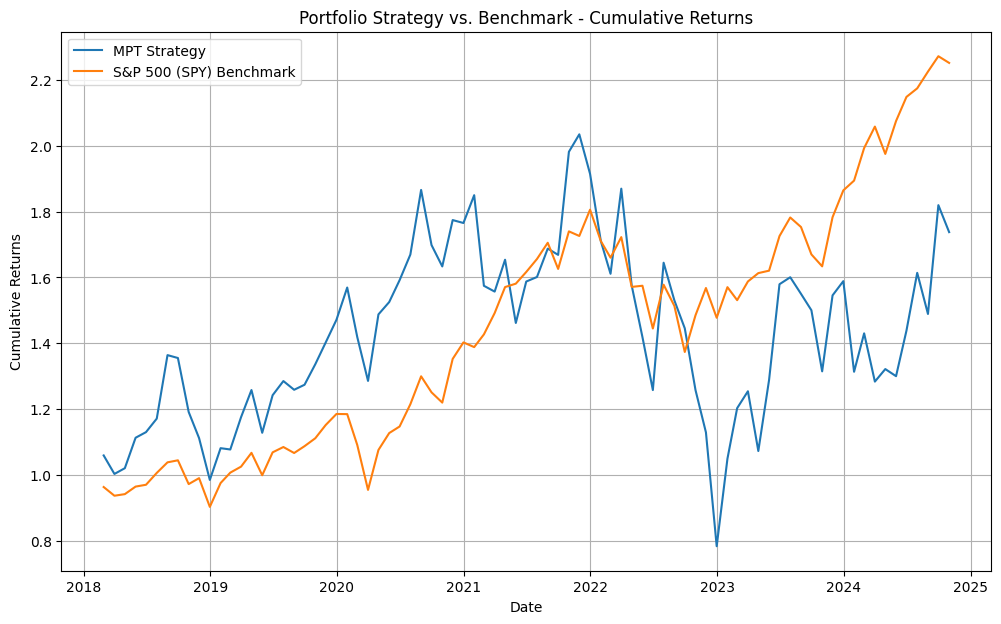

In [58]:
import matplotlib.pyplot as plt

# Align benchmark returns with your strategy's dates
aligned_benchmark = benchmark_returns.loc[backtest_results.index]

# Calculate cumulative returns
cumulative_strategy_returns = (1 + backtest_results).cumprod()
cumulative_benchmark_returns = (1 + aligned_benchmark).cumprod()

# Plot the results
plt.figure(figsize=(12, 7))
plt.plot(cumulative_strategy_returns, label='MPT Strategy')
plt.plot(cumulative_benchmark_returns, label='S&P 500 (SPY) Benchmark')
plt.title('Portfolio Strategy vs. Benchmark - Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

## Phase 3

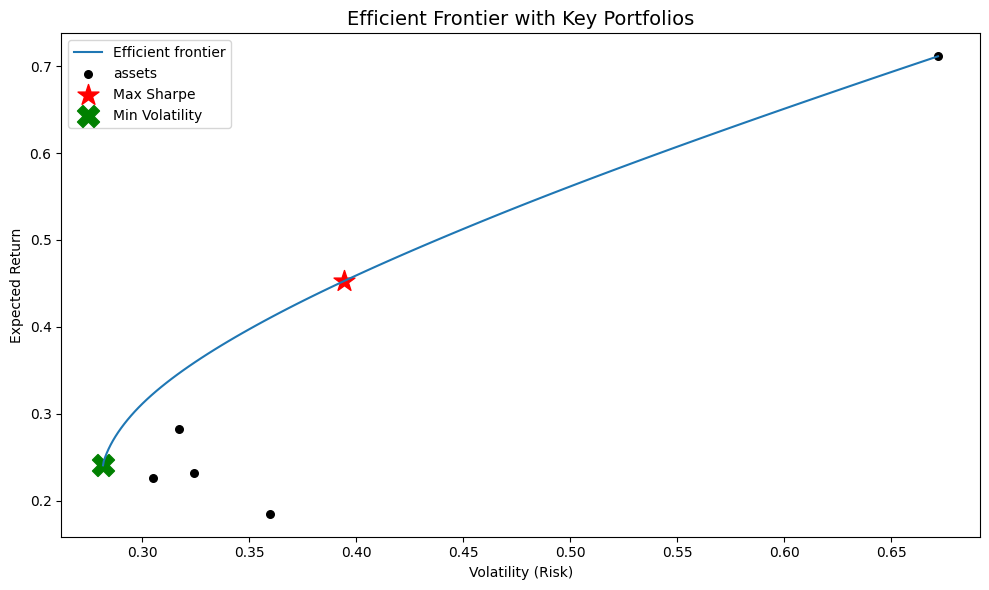

In [46]:
from pypfopt import plotting, expected_returns, risk_models, EfficientFrontier
import matplotlib.pyplot as plt

# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

# --- Efficient Frontier ---
ef = EfficientFrontier(mu, S)
fig, ax = plt.subplots(figsize=(10,6))
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)

# --- Max Sharpe Portfolio ---
ef_sharpe = EfficientFrontier(mu, S)  # fresh instance
weights_sharpe = ef_sharpe.max_sharpe()
ret_sharpe, risk_sharpe, _ = ef_sharpe.portfolio_performance()
ax.scatter(risk_sharpe, ret_sharpe, marker="*", color="r", s=250, label="Max Sharpe")

# --- Min Volatility Portfolio ---
ef_vol = EfficientFrontier(mu, S)  # fresh instance
weights_vol = ef_vol.min_volatility()
ret_vol, risk_vol, _ = ef_vol.portfolio_performance()
ax.scatter(risk_vol, ret_vol, marker="X", color="g", s=250, label="Min Volatility")

# Style
ax.set_title("Efficient Frontier with Key Portfolios", fontsize=14)
ax.set_xlabel("Volatility (Risk)")
ax.set_ylabel("Expected Return")
ax.legend()
plt.tight_layout()
plt.show()


In [25]:
# 2: Add Constraints- to simulate real world investment rules
# Example 1: No single asset can be more than 30% of the portfolio
ef_constrained = EfficientFrontier(mu, S, weight_bounds=(0, 0.30))

# Example 2: Sector constraints (e.g., Tech stocks max 50%)
# Let's assume MSFT, AAPL, GOOG, AMZN are tech
tech_tickers = ["MSFT", "AAPL", "GOOG", "AMZN"]
other_tickers = ["TSLA"] # In this small example

sector_mapper = {ticker: "Tech" for ticker in tech_tickers}
sector_mapper.update({ticker: "Other" for ticker in other_tickers})

sector_lower = {} 
sector_upper = {"Tech": 0.50} # Max 50% allocation to tech

ef_sector = EfficientFrontier(mu, S)
ef_sector.add_sector_constraints(sector_mapper, sector_lower, sector_upper)

# You can now run optimizations like max_sharpe() on these constrained objects
weights = ef_sector.max_sharpe()
print(ef_sector.portfolio_performance(verbose=True))

Expected annual return: 49.3%
Annual volatility: 43.1%
Sharpe Ratio: 1.14
(0.4933057081120213, 0.4312450593293525, 1.143910399528245)


## Phase 4: Using more Advanced Inputs
Improve your model's inputs to make them more forward-looking and robust. This is a one-line change for each calculation

In [26]:
# Original inputs
mu_historical = expected_returns.mean_historical_return(df)
S_sample = risk_models.sample_cov(df)

# ADVANCED INPUTS
# 1. Use Exponentially Weighted Covariance (gives more weight to recent data)
S_exp = risk_models.exp_cov(df, span=180) # Use 180 days of data as the span

# 2. Use CAPM for Expected Returns (considers market risk)
mu_capm = expected_returns.capm_return(df)

# Now, run your optimization with these improved inputs
ef_advanced = EfficientFrontier(mu_capm, S_exp)
weights_advanced = ef_advanced.max_sharpe()
print(ef_advanced.portfolio_performance(verbose=True))

Expected annual return: 31.1%
Annual volatility: 18.4%
Sharpe Ratio: 1.69
(0.31118030332746727, 0.184369301308846, 1.6878097444552007)


C:\Users\nikib\AppData\Local\Temp\ipykernel_1408\53666719.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  all_data = yf.download(all_tickers, start="2012-01-01", end="2024-12-31")['Close']
[*********************100%***********************]  6 of 6 completed
C:\Users\nikib\AppData\Local\Temp\ipykernel_1408\53666719.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = all_data.resample('M').last().pct_change().dropna()


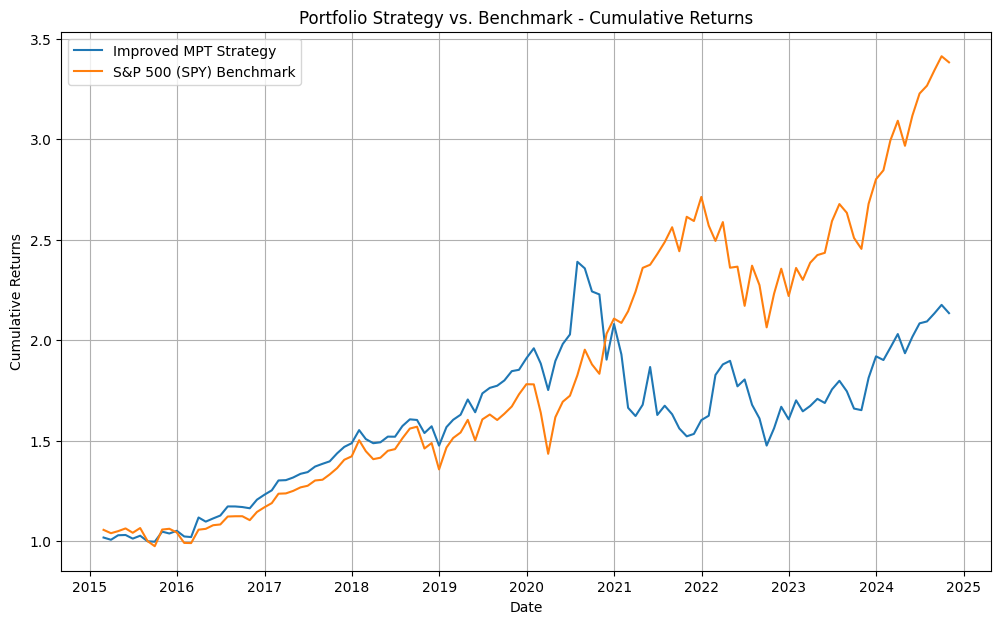

In [62]:
# Optimizing again by adding diversification
import yfinance as yf
import pandas as pd
import numpy as np
from pypfopt import EfficientFrontier, risk_models, expected_returns
from pypfopt.risk_models import CovarianceShrinkage
import matplotlib.pyplot as plt

# --- CHANGE 1: Use a diversified set of assets ---
tickers = ["SPY", "AGG", "GLD", "VNQ", "MSFT", "JPM"] # Stocks, Bonds, Gold, Real Estate, Tech, Finance
benchmark_ticker = "SPY"

# Download historical data
all_tickers = list(set(tickers + [benchmark_ticker])) # Use set to avoid duplicates
all_data = yf.download(all_tickers, start="2012-01-01", end="2024-12-31")['Close']

# Calculate monthly returns
monthly_returns = all_data.resample('M').last().pct_change().dropna()
asset_returns = monthly_returns[tickers]
benchmark_returns = monthly_returns[benchmark_ticker]

# Strategy Parameters
rebalance_frequency = 3 # Quarterly rebalancing
rolling_window = 36 # 3 years of data for optimization

portfolio_returns = []
dates = []
all_weights = []

# The main backtesting loop
for i in range(rolling_window, len(monthly_returns) - rebalance_frequency, rebalance_frequency):
    
    # 1. Define the current rolling window for optimization
    window_start = i - rolling_window
    window_end = i
    
    # Use monthly returns for optimization inputs, not daily prices
    current_window_returns = monthly_returns.iloc[window_start:window_end]
    
    # 2. Optimize the portfolio using ADVANCED inputs and constraints
    
    # --- CHANGE 2: Use more robust inputs for mu and S ---
    # Use Exponential Moving Average for returns to weigh recent data more
    mu = expected_returns.ema_historical_return(current_window_returns[tickers], frequency=12)
    
    # Use Ledoit-Wolf Shrinkage for the covariance matrix
    S = CovarianceShrinkage(current_window_returns[tickers], frequency=12).ledoit_wolf()
    
    # --- CHANGE 3: Add constraints to the optimization ---
    # Set a max weight of 40% for any single asset
    ef = EfficientFrontier(mu, S, weight_bounds=(0, 0.40)) 
    
    try:
        weights = ef.max_sharpe()
        cleaned_weights = ef.clean_weights()
        all_weights.append(cleaned_weights)
    except Exception as e:
        print(f"Optimization failed at step {i}. Error: {e}")
        # If optimization fails, carry forward the last successful weights
        if all_weights:
             cleaned_weights = all_weights[-1]
        else:
             continue # Skip this period if it's the first and it fails

    # 3. Define the holding period
    hold_start = i
    hold_end = i + rebalance_frequency
    holding_period_returns = asset_returns.iloc[hold_start:hold_end]
    
    # 4. Calculate portfolio returns for the holding period
    period_portfolio_return = np.sum(holding_period_returns * list(cleaned_weights.values()), axis=1)
    
    # 5. Store the results
    portfolio_returns.extend(period_portfolio_return)
    dates.extend(period_portfolio_return.index)

# Create a final DataFrame with the results
backtest_results = pd.Series(portfolio_returns, index=dates)

# --- Plotting the Results ---
# Align benchmark returns with your strategy's dates
aligned_benchmark = benchmark_returns.loc[backtest_results.index]

# Calculate cumulative returns
cumulative_strategy_returns = (1 + backtest_results).cumprod()
cumulative_benchmark_returns = (1 + aligned_benchmark).cumprod()

# Plot the results
plt.figure(figsize=(12, 7))
plt.plot(cumulative_strategy_returns, label='Improved MPT Strategy')
plt.plot(cumulative_benchmark_returns, label='S&P 500 (SPY) Benchmark')
plt.title('Portfolio Strategy vs. Benchmark - Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\nikib\AppData\Local\Temp\ipykernel_1408\858652298.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  all_data = yf.download(all_tickers, start="2012-01-01", end="2024-12-31")['Adj Close']
[*********************100%***********************]  6 of 6 completed


KeyError: 'Adj Close'